In [216]:
import emissions_calculator
import pandas as pd
import numpy as np

In [217]:
dir(emissions_calculator)

['CALCULATOR_FOLDER',
 'CWD',
 'DAYS_IN_MONTH',
 'DIR_CALCULATOR',
 'DIR_DATA_IN',
 'DIR_DATA_PROC',
 'DIR_DR_POTENTIAL_HRS',
 'DIR_EMISSIONS_RATES',
 'DR_HRS_FILES',
 'DR_NAME',
 'DR_POTENTIAL_FILES',
 'DR_SEASONS',
 'EMISSIONS_CHANGEUNITS',
 'EMISSIONS_RATES_FILES',
 'EMISSIONS_SCENARIO_LIST',
 'MAIN_FOLDER',
 'SUBSET_PRODUCTS',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'create_dr_hours_df_dict',
 'create_dr_potential_df_dict',
 'create_emissions_rates_df',
 'create_product_info_df',
 'emissions_parameters',
 'os',
 'pd',
 'runall',
 'subcomp_a_organize_data']

In [288]:
[emissions_rates_df_out, dr_hours_df_dict_out, \
            dr_potential_df_dict_out, dr_product_info_df_dict_out] = emissions_calculator.runall()

In [393]:
emissions_calculator.emissions_parameters.DR_NAME

['oldbins', 'newbins']

In [219]:
emissions_calculator.emissions_parameters.EMISSIONS_CHANGEUNITS

0.4536

In [316]:
print(dr_hours_df_dict_out['newbins_Fall'][7000:7024])

      hourID  Month  Day  DVR  ResTOU
7000      17     10   19    0       0
7001      18     10   19    1       1
7002      19     10   19    1       1
7003      20     10   19    1       1
7004      21     10   19    1       1
7005      22     10   19    0       0
7006      23     10   19    0       0
7007      24     10   19    0       0
7008       1     10   20    0       0
7009       2     10   20    0       0
7010       3     10   20    0       0
7011       4     10   20    0       0
7012       5     10   20    0       0
7013       6     10   20    0       0
7014       7     10   20    0       0
7015       8     10   20    0       0
7016       9     10   20    0       0
7017      10     10   20    0       0
7018      11     10   20    0       0
7019      12     10   20    0       0
7020      13     10   20    0       0
7021      14     10   20    0       0
7022      15     10   20    0       0
7023      16     10   20    0       0


In [385]:
dr_hours = dr_hours_df_dict_out['newbins_Fall']
dr_hours = dr_hours[["hourID", "Month", "Day", "ResTOU"]]
dr_product = dr_hours.columns[-1]
#Get indecies/values
vals = dr_hours[dr_product].values

#Get to get first index in set of 4
indecies = dr_hours.loc[dr_hours.ResTOU==1].index
firsts = np.array([])
first = True
ind_prev = 0
for ind in (indecies):
    print(ind-ind_prev)
    if first:
        firsts = np.append(firsts, np.array([np.floor(ind)]))
        first = False
        ind_prev = ind
    else:
        if ind-ind_prev > 1:
            first = True
        else:
            first = False
            
        ind_prev = ind

firsts = firsts.astype(int)
shift_inds_down_2 = firsts - 2
shift_inds_down_1 = firsts - 1
shift_inds_up_1 = firsts + 1
shift_inds_up_2 = firsts + 2
#indecies = indecies + shift
indecies = np.append(shift_inds_down_2,shift_inds_down_1)
indecies = np.append(indecies,shift_inds_up_1)
indecies = np.append(indecies,shift_inds_up_2)

dr_product_shifted = dr_hours['ResTOU']
dr_product_shifted.loc[indecies] -= 1

dr_hours.ResTOU = dr_product_shifted.values


6569
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
45
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
45
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
45
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
117
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
45
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
45
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
45
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
93
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
45
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
45
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
45
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1
21
1
1
1


-1

In [390]:
len(firsts)*4

288

In [ ]:
#Ok so wtf am I doing?
#Start with New Binning:
#ResTOU and DVR:
def load_data():
    """
    Function just runs the subcomponent_a to load the data and returns the expected dictionaries and dataframes
    """
    
    [em_rates, dr_hours, dr_potential, dr_product_info] = emissions_calculator.runall()
    return(em_rates, dr_hours, dr_potential, dr_product_info)


In [224]:
#Function to do ResTOU shifting
def shift_hours(dr_hours, shift_hours):
    """
    do something to get the shifted hrs 
    Add -1s to hrs where we want to shift to.
    
    input: dr_hours: Just the dataframe of the hours for this dr item
    
    output: how many hours to shift to shifting window
    
    only shift -2 hrs +2hrs 
    """
    
    #Baseline hours for newbins is 18-21
    
    #Find where index is 1:
    #dr_product = dr_hours.columns[-1]
    #Get indecies/values
    #product_inds = dr_hours.index[dr_hours[dr_product].values]
    
    
    
    dr_hours = dr_hours_df_dict_out['newbins_Fall']
    dr_hours = dr_hours[["hourID", "Month", "Day", "ResTOU"]]
    dr_product = dr_hours.columns[-1]
    #Get indecies/values
    vals = dr_hours[dr_product].values

    #Get to get first index in set of 4
    indecies = dr_hours.loc[dr_hours.ResTOU==1].index
    firsts = np.array([])
    first = True
    ind_prev = 0
    for ind in (indecies):
        print(ind-ind_prev)
        if first:
            firsts = np.append(firsts, np.array([np.floor(ind)]))
            first = False
            ind_prev = ind
        else:
            if ind-ind_prev > 1:
                first = True
            else:
                first = False

            ind_prev = ind

    firsts = firsts.astype(int)
    shift_inds_down_2 = firsts - shift_hours
    shift_inds_down_1 = firsts - (shift_hours-1)
    shift_inds_up_1 = firsts + (shift_hours-1)
    shift_inds_up_2 = firsts + shift_hours
    #indecies = indecies + shift
    indecies = np.append(shift_inds_down_2,shift_inds_down_1)
    indecies = np.append(indecies,shift_inds_up_1)
    indecies = np.append(indecies,shift_inds_up_2)

    dr_product_shifted = dr_hours['ResTOU']
    dr_product_shifted.loc[indecies] -= 1

    dr_hours.ResTOU = dr_product_shifted.values
    
    return(dr_hours.ResTOU)

In [467]:
#Find the hours where we're doing the resTOU and multiply potential by emissions rate
#by potential

def calc_yearly_avoided_emissions_newbins(em_rates, dr_hours, dr_potential, dr_product_info):
    """
    This function uses the loaded data and calculated yearly avoided emissions for the new binning
    Currently only DVR and ResTOU shed 
    """
    summer_hrs = dr_hours_df_dict_out['newbins_Summer']
    summer_pot = dr_potential_df_dict_out['newbins_Summer']
    winter_pot = dr_potential_df_dict_out['newbins_Winter']
    winter_hrs = dr_hours_df_dict_out['newbins_Winter']
    fall_hrs = dr_hours_df_dict_out['newbins_Fall']
    fall_pot = dr_potential_df_dict_out['newbins_Winter']

    #Emissions rates
    em_rates = emissions_rates_df_out;

    #use summer_hrs to get the products we're setting
    DR_list = list(summer_hrs.columns.values[3:])
    
    #Seasons for newbins
    seasons = ['Fall', 'Winter', 'Summer']
    
    #Get separate names for each DR+Season
    #dr_season_names = [np.zeros(len(DR_list)*len(seasons))]
    dr_season_names = [];
    for i in range(len(DR_list)):
        for j in range(len(seasons)):
            dr_season_names = dr_season_names + [DR_list[i]+"_"+seasons[j]]
    print(dr_season_names)
        
    

    #List of DR products that we need to calculate this for
    #DR_list = ['ResTOU', 'DVR']

    #List of years we're calculating for
    year_start = min(em_rates.Report_Year)
    year_end = max(em_rates.Report_Year)
    years = np.arange(year_start, year_end+1)

    #Create Dataframe with year and DR products as columns
    #yearly_avoided = pd.DataFrame({"Year": years, "Res": np.zeros(len(years))})
    start_matrix = np.zeros((len(years), len(DR_list)*len(seasons)+1))
    start_matrix[:, 0] = years.astype(int)
    yearly_avoided = pd.DataFrame(data = start_matrix, columns=['Year']+dr_season_names)


    print((start_matrix.shape))
    for DR in DR_list:
        print(DR)
        summer_hrs_dr = summer_hrs.where(summer_hrs[DR]==1);
        #print(summer_hrs_dr)
        winter_hrs_dr = winter_hrs.where(winter_hrs[DR]==1)
        fall_hrs_dr = fall_hrs.where(fall_hrs[DR]==1)
        em_rates = em_rates.rename({'Report_Month': 'Month', 'Report_Day': 'Day', "Report_Hour": "hourID"}, axis='columns')


        #res_TOU_yearly = pd.DataFrame({"Year": years, "emissions": np.zeros(len(years))})
        for year in range(year_start, year_end+1):


            dr_summer_pot = summer_pot[DR].loc[summer_pot.Year==year]
            #print(dr_summer_pot)
            dr_winter_pot = winter_pot[DR].loc[winter_pot.Year==year]
            dr_fall_pot = fall_pot[DR].loc[fall_pot.Year==year]
            short_df = em_rates.loc[em_rates.Report_Year==year]
            if year%4==0:
                #Then we've got a leap year, so this math isn't going to work out bc summer_hrs only has 365 days
                #Looks like there's no DR on leap years, so we can ignore that extra time (last 24 entries)
                short_df = short_df.iloc[:-24];
            #Multiply baseline emissions by potential for all hours
            summer_out_arr = short_df["Baseline Emissions Rate Estimate"].values*summer_hrs[DR].values*dr_summer_pot.values
            winter_out_arr = short_df["Baseline Emissions Rate Estimate"].values*winter_hrs[DR].values*dr_winter_pot.values
            fall_out_arr = short_df["Baseline Emissions Rate Estimate"].values*fall_hrs[DR].values*dr_fall_pot.values

            print(summer_hrs[DR].values)
            summer_out_arr = summer_out_arr * emissions_calculator.emissions_parameters.EMISSIONS_CHANGEUNITS
            winter_out_arr = winter_out_arr * emissions_calculator.emissions_parameters.EMISSIONS_CHANGEUNITS
            fall_out_arr = fall_out_arr * emissions_calculator.emissions_parameters.EMISSIONS_CHANGEUNITS

            summer_yearly_sum = summer_out_arr.sum()
            winter_yearly_sum = winter_out_arr.sum()
            fall_yearly_sum = fall_out_arr.sum()
            
            yearly_avoided[DR+"_Fall"].iloc[year-year_start] = fall_yearly_sum
            yearly_avoided[DR+"_Winter"].iloc[year-year_start] = winter_yearly_sum
            yearly_avoided[DR+"_Summer"].iloc[year-year_start] = summer_yearly_sum
            #dr_yearly_sum = summer_yearly_sum + winter_yearly_sum + fall_yearly_sum

            #yearly_avoided[DR].iloc[year-year_start] = dr_yearly_sum

    return(yearly_avoided)

In [468]:
yearly_avoided = calc_yearly_avoided_emissions_newbins(emissions_rates_df_out, dr_hours_df_dict_out, dr_potential_df_dict_out, dr_product_info_df_dict_out)

['DVR_Fall', 'DVR_Winter', 'DVR_Summer', 'ResTOU_Fall', 'ResTOU_Winter', 'ResTOU_Summer']
(20, 7)
DVR
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
ResTOU
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


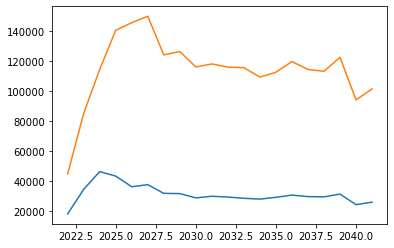

In [458]:
import matplotlib.pyplot as plt

#plt.plot(res_TOU_yearly['Year'], res_TOU_yearly["emissions"])
plt.plot(yearly_avoided['Year'], yearly_avoided['ResTOU_Fall']+yearly_avoided["ResTOU_Winter"] + yearly_avoided["ResTOU_Summer"])
plt.plot(yearly_avoided['Year'], yearly_avoided['DVR_Fall']+yearly_avoided["DVR_Winter"] + yearly_avoided["DVR_Summer"])


#plt.plot(yearly_avoided['Year'], yearly_avoided['DVR'])
#np.arange(year_start, year_end+1)

In [429]:
foo = {};
foo['blah'] = [1]
foo['blah'] = foo['blah']+[2]
foo
foo.keys()

dict_keys(['blah'])

In [436]:
#dr_names = ['NRCurtailCom', 'NRCurtailInd', 'DVR', 'IndRTP', 'ResCPP', 'ResTOU', 'NRHeatSwchMed', 'NRHeatSwchSm', 'ComCPP', 'IndCPP', 'NRTstatSm', 'ResBYOT', 'ResHeatSwitch', 'ResERWHDLCSwch', 'ResERWHDLCGrd', 'ResEVSEDLCSwch', 'ResHPWHDLCSwch', 'ResHPWHDLCGrd'];
#dr_info = dr_product_info['oldbins']
def sort_bins(dr_info, dr_names):
    """
    make dictionary with bin number as key and names as values
    """
    out_dict = {}

    for dr in dr_names:
        bin_name = dr_info.Bin.loc[dr_info.Product == dr].values[0]
        if bin_name in list(out_dict.keys()):
            out_dict[bin_name] = out_dict[bin_name]+[dr]
        else:
            out_dict[bin_name] = [dr]

    return(out_dict)    

In [477]:
#Find the hours where we're doing the resTOU and multiply potential by emissions rate
#by potential

#def calc_yearly_avoided_emissions(em_rates, dr_hours, dr_potential, dr_product_info):
"""
This function uses the loaded data and calculated yearly avoided emissions for the new binning
Currently only DVR and ResTOU shed 
"""
    
bins = emissions_calculator.emissions_parameters.DR_NAME
seasons = emissions_calculator.emissions_parameters.DR_SEASONS

#Get the start and end years and a list of years. 
#These are constant across newbins/oldbins, etc.
year_start = min(em_rates.Report_Year)
year_end = max(em_rates.Report_Year)
years = np.arange(year_start, year_end+1)

#Loop over old_bins + new_bins
for i in range(len(bins)):
    binning = bins[i];
    dr_info = dr_product_info[binning]
    #Get list of DR names for 
    #print(binning)
    for season in seasons[i]:
        combo_name = binning + "_" + season
        hrs = dr_hours_df_dict_out[combo_name]
        pot = dr_potential_df_dict_out[combo_name]
        #This assumes we have the same formatted DF everytime
        DR_list = list(hrs.columns.values[3:])
        bin_dict = sort_bins(dr_info, DR_list)
        #Loop over every bin number
        for bin_num in list(bin_dict.keys()):
            bin_drs = bin_dict[bin_num]
            #print(bin_drs)
            start_matrix = np.zeros((len(years), len(bin_drs)+1))
            start_matrix[:, 0] = years.astype(int)
            yearly_avoided = pd.DataFrame(data = start_matrix, columns=['Year']+bin_drs)
            
            for dr in bin_drs:
                print(dr)
                print(max(hrs[dr]))
                #dr_hrs = hrs.where(hrs[dr]==1)
                #print(dr_hrs)
                #Think I rename things so dataframes more easily compared
                em_rates = em_rates.rename({'Report_Month': 'Month', 'Report_Day': 'Day', "Report_Hour": "hourID"}, axis='columns')

                for year in range(year_start, year_end+1):
                    dr_pot = pot[dr].loc[pot.Year==year]
                    short_df = em_rates.loc[em_rates.Report_Year==year]
                    #print(dr_hrs)
                    if year%4==0:
                        #Then we've got a leap year, so this math isn't going to work out bc summer_hrs only has 365 days
                        #Looks like there's no DR on leap years, so we can ignore that extra time (last 24 entries)
                        short_df = short_df.iloc[:-24];

                    #Multiply baseline emissions by potential for all hours
                    out_arr = short_df["Baseline Emissions Rate Estimate"].values*hrs[dr].values*dr_pot.values
                    #print(hrs[dr].values)
                    #print(out_arr)
                    out_arr = out_arr * emissions_calculator.emissions_parameters.EMISSIONS_CHANGEUNITS

                    yearly_sum = out_arr.sum()
                    #print(yearly_sum)
                    yearly_avoided[dr].iloc[year-year_start] = yearly_sum
            save_name = binning+"_"+bin_num.split()[0]+"_"+bin_num.split()[1]+"_"|+season;
            yearly_avoided.to_csv("/Users/jamesstadler/Documents/UW/Courses/CSE583/DR-Emissions-Project/Main/processed_data/subcomp_d_data/"+save_name+".csv")
            print(yearly_avoided)

        #use hrs to get the products we're setting

"""
#Get separate names for each DR+Season
#dr_season_names = [np.zeros(len(DR_list)*len(seasons))]



#List of DR products that we need to calculate this for
#DR_list = ['ResTOU', 'DVR']

#List of years we're calculating for


#Create Dataframe with year and DR products as columns
#yearly_avoided = pd.DataFrame({"Year": years, "Res": np.zeros(len(years))})
start_matrix = np.zeros((len(years), len(DR_list)*len(seasons)+1))
start_matrix[:, 0] = years.astype(int)
yearly_avoided = pd.DataFrame(data = start_matrix, columns=['Year']+dr_season_names)


print((start_matrix.shape))
for DR in DR_list:
    #print(DR)
    summer_hrs_dr = summer_hrs.where(summer_hrs[DR]==1);
    winter_hrs_dr = winter_hrs.where(winter_hrs[DR]==1)
    fall_hrs_dr = fall_hrs.where(fall_hrs[DR]==1)
    em_rates = em_rates.rename({'Report_Month': 'Month', 'Report_Day': 'Day', "Report_Hour": "hourID"}, axis='columns')


    #res_TOU_yearly = pd.DataFrame({"Year": years, "emissions": np.zeros(len(years))})
    for year in range(year_start, year_end+1):


        dr_summer_pot = summer_pot[DR].loc[summer_pot.Year==year]
        dr_winter_pot = winter_pot[DR].loc[winter_pot.Year==year]
        dr_fall_pot = fall_pot[DR].loc[fall_pot.Year==year]
        short_df = em_rates.loc[em_rates.Report_Year==year]
        if year%4==0:
            #Then we've got a leap year, so this math isn't going to work out bc summer_hrs only has 365 days
            #Looks like there's no DR on leap years, so we can ignore that extra time (last 24 entries)
            short_df = short_df.iloc[:-24];
        #Multiply baseline emissions by potential for all hours
        summer_out_arr = short_df["Baseline Emissions Rate Estimate"].values*summer_hrs[DR].values*dr_summer_pot.values
        winter_out_arr = short_df["Baseline Emissions Rate Estimate"].values*winter_hrs[DR].values*dr_winter_pot.values
        fall_out_arr = short_df["Baseline Emissions Rate Estimate"].values*fall_hrs[DR].values*dr_fall_pot.values

        summer_out_arr = summer_out_arr * emissions_calculator.emissions_parameters.EMISSIONS_CHANGEUNITS
        winter_out_arr = winter_out_arr * emissions_calculator.emissions_parameters.EMISSIONS_CHANGEUNITS
        fall_out_arr = fall_out_arr * emissions_calculator.emissions_parameters.EMISSIONS_CHANGEUNITS

        summer_yearly_sum = summer_out_arr.sum()
        winter_yearly_sum = winter_out_arr.sum()
        fall_yearly_sum = fall_out_arr.sum()

        yearly_avoided[DR+"_Fall"].iloc[year-year_start] = fall_yearly_sum
        yearly_avoided[DR+"_Winter"].iloc[year-year_start] = winter_yearly_sum
        yearly_avoided[DR+"_Summer"].iloc[year-year_start] = summer_yearly_sum
        #dr_yearly_sum = summer_yearly_sum + winter_yearly_sum + fall_yearly_sum

        #yearly_avoided[DR].iloc[year-year_start] = dr_yearly_sum

return(yearly_avoided)
"""

NRCurtailCom
1
NRCurtailInd
1
ResTOU
1
NRHeatSwchMed
1
ResBYOT
1


IndexError: list index out of range

In [478]:
binning

'oldbins'

In [412]:
dr_product_info = dr_product_info_df_dict_out
dr_product_info['oldbins']

,Product,Bin,Seasonality,Shift or Shed?
0,NRCurtailCom,Bin 2,Year-round,Shift
1,NRCurtailInd,Bin 2,Year-round,Shift
2,NRIrrLg,Bin 1,Summer,Shed
3,NRIrrSmMed,Bin 1,Summer,Shed
4,ComCPP,Bin 1,Year-round,Shed
5,IndCPP,Bin 1,Year-round,Shed
6,DVR,Bin 1,Year-round,Shed
7,IndRTP,Bin 1,Year-round,Shift
8,ResCPP,Bin 1,Year-round,Shed
9,ResTOU,Bin 2,Year-round,Shift


In [476]:
"Bin 1".split()

['Bin', '1']